# Análisis de Telemetría de Sesiones
**Autor:** Grupo 05  
**Fecha:** 2025-03-27  

**Objetivo:**  
Comprobar que el uso de las armas se adecúa al objetivo para el que fueron diseñadas.

**Preguntas de investigación:**  
1. ¿Se usan las armas a las distancias para las que fueron diseñadas?  
2. ¿Se adecúa el uso al diseño de los niveles 2 y 3?  
3. ¿La dispersión de la escopeta es intuitiva y adecuada?

## 1. Introducción

**Objetivo:**  
Comprobar que el uso de las armas se adecúa al objetivo para el que fueron diseñadas.

**Preguntas de investigación:**  
1. ¿Se usan las armas a las distancias para las que fueron diseñadas?  
2. ¿Se adecúa el uso al diseño de los niveles 2 y 3?  
3. ¿La dispersión de la escopeta es intuitiva y adecuada?

## 2. Imports y configuración inicial

In [517]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')
DATA_DIR = 'data'


## 3. Carga y vista previa de los JSON

In [518]:
# Carga y vista previa de los JSON
import pandas as pd

# Listar archivos
paths = glob.glob(os.path.join(DATA_DIR, 'telemetry_*.json'))
print(f"{len(paths)} archivos JSON encontrados.")


# Cargar en DataFrame
df = pd.concat([pd.read_json(p) for p in paths], ignore_index=True)

# 6) Vistazo final
print(df.dtypes[['sessionID','timestamp']])
#df[['sessionID','timestamp']].head(5)



10 archivos JSON encontrados.
sessionID            object
timestamp    datetime64[ns]
dtype: object


## 4. Preprocesado de eventos
- Separar eventos de `Shot` y `ShotCollision`.
- Parsear la columna `otherWeaponsInfo` a diccionario.
- Unir cada disparo con su colisión mediante `sessionID + bulletID`.

In [519]:
# Preprocesado de eventos

import json, ast

# Extraer Shot y ShotCollision
shots = df[df.eventType == 'Shot'].copy()
colls = df[df.eventType == 'ShotCollision'].copy()

print(f"Disparos (Shot): {len(shots)} filas")
print(f"Colisiones (ShotCollision): {len(colls)} filas\n")

# Parsear otherWeaponsInfo a dict (JSON o literal de Python)
def _parse_other(info):
    if isinstance(info, dict):
        return info
    if pd.isna(info) or info == '':
        return {}
    if isinstance(info, str):
        try:
            return json.loads(info)
        except:
            try:
                return ast.literal_eval(info)
            except:
                return {}
    return {}

shots['otherWeaponsInfo'] = shots['otherWeaponsInfo'].apply(_parse_other)

# Unir disparos con colisiones (sessionID + bulletID) usando suffixes
merged = pd.merge(
    shots,
    colls,
    on=['sessionID','bulletID'],
    how='left',
    suffixes=('','_coll')
)

# Vista previa
print("Columnas tras merge:", merged.columns.tolist(), "\n")
#merged.head()



Disparos (Shot): 1098 filas
Colisiones (ShotCollision): 1331 filas

Columnas tras merge: ['eventType', 'gameID', 'playerID', 'sessionID', 'timestamp', 'levelStarted', 'bulletID', 'otherWeaponsInfo', 'posX', 'posY', 'posZ', 'weaponUsed', 'hasHitEnemy', 'hasKillEnemy', 'eventType_coll', 'gameID_coll', 'playerID_coll', 'timestamp_coll', 'levelStarted_coll', 'otherWeaponsInfo_coll', 'posX_coll', 'posY_coll', 'posZ_coll', 'weaponUsed_coll', 'hasHitEnemy_coll', 'hasKillEnemy_coll'] 



## 5. Métricas de uso óptimo por distancia
- Calcular distancia entre `posX,posY,posZ` de disparo y colisión.
- Categorizar en “corta” (0–12 m), “media” (12–25 m) y “larga” (25–60 m).
- Filtrar solo disparos con munición en otras armas.
- Para pistola, escopeta y rifle, calcular % de impactos en cada rango.

Impactos brutos por arma y franja:


C:\Users\javim\AppData\Local\Temp\ipykernel_16920\3467124876.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['weaponUsed','range_cat'])


range_cat,corta,media,larga
weaponUsed,,,
Pistola,144,260,307
Escopeta,7,41,44
Rifle,6,29,33


% de impactos por franja (normalizado por arma):


range_cat,corta,media,larga
weaponUsed,,,
Pistola,20,37,43
Escopeta,8,45,48
Rifle,9,43,48


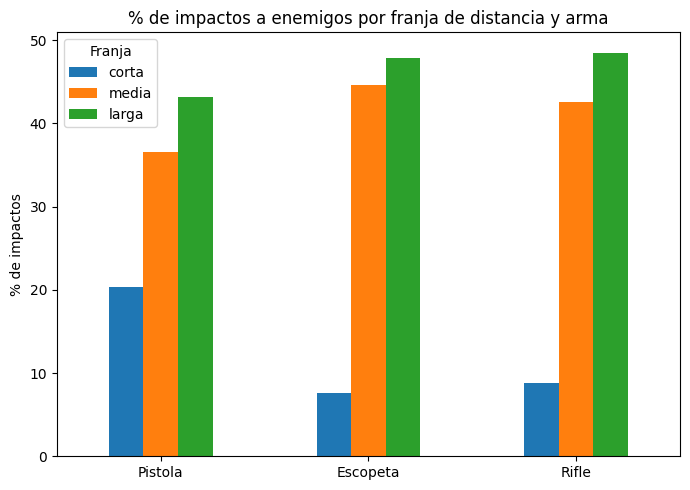

In [534]:
# 5. Métricas de uso óptimo por distancia (hits por franja / hits totales por arma)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Partimos de merged_shot (debe traer posX, posY, posZ, posX_coll, posY_coll, posZ_coll, weaponUsed, hasHitEnemy)
df5 = merged_shot.copy()

# 1) Filtrar solo los impactos reales
hits = df5[df5['hasHitEnemy'] == 1].copy()

# 2) Calcular distancia 3D
hits['distance'] = np.sqrt(
    (hits['posX']     - hits['posX_coll'])**2 +
    (hits['posY']     - hits['posY_coll'])**2 +
    (hits['posZ']     - hits['posZ_coll'])**2
)

# 3) Categorizar en franjas
bins   = [0, 12, 25, 60]
labels = ['corta','media','larga']
hits['range_cat'] = pd.cut(hits['distance'], bins=bins, labels=labels, right=False)

# 4) Contar impactos por arma y franja (raw hits)
raw_hits = (
    hits
    .groupby(['weaponUsed','range_cat'])
    .size()
    .unstack(fill_value=0)
    .rename(index={0:'Pistola',1:'Escopeta',2:'Rifle'})
)
print("Impactos brutos por arma y franja:")
display(raw_hits)

# 5) Calcular %: cada franja ÷ total impactos de esa arma
pct_hits = raw_hits.div(raw_hits.sum(axis=1), axis=0) * 100
pct_hits = pct_hits.round(1)
print("% de impactos por franja (normalizado por arma):")
display(pct_hits)

# 6) Gráfico para visualizar la distribución
ax = pct_hits.plot.bar(
    figsize=(7,5),
    title='% de impactos a enemigos por franja de distancia y arma',
    ylabel='% de impactos'
)
ax.set_xlabel('')
plt.xticks(rotation=0)
plt.legend(title='Franja')
plt.tight_layout()
plt.show()



## 6. Uso de escopeta y rifle por nivel (2 y 3)
- Asignar a cada disparo el nivel usando orden de eventos y `ffill`.
- Filtrar nivel 2 y nivel 3.
- Comparar % de pistola vs escopeta en nivel 2.
- Comparar % de pistola, escopeta y rifle en nivel 3.

Disparos por nivel:
 level
1    274
2    352
3    472
Name: count, dtype: int64 



,Disparos,% Disparos
weaponUsed,,
Pistola,282,80
Escopeta,70,20


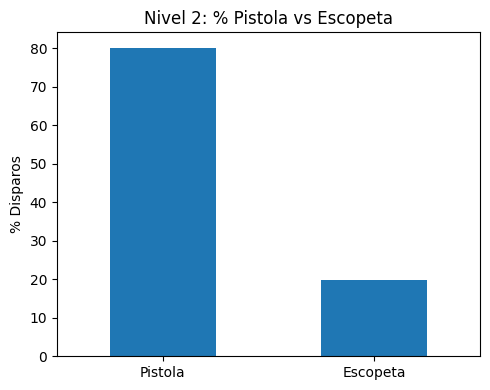

,Disparos,% Disparos
weaponUsed,,
Pistola,353,75
Escopeta,45,10
Rifle,74,16


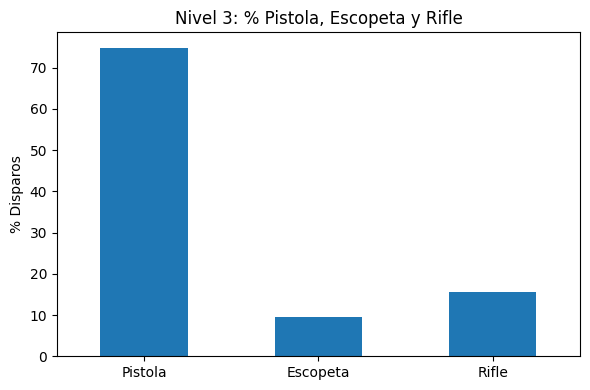

In [521]:
import pandas as pd
import numpy as np

# Uso de escopeta y rifle por nivel (2 y 3) — colisiones deduplicadas

# Preservamos el orden original
df_ord = df.reset_index().rename(columns={'index':'orig_order'})

# Preparamos shot_df con orig_order
shot_df = df_ord[df_ord.eventType=='Shot'][[
    'orig_order','sessionID','bulletID','weaponUsed',
    'posX','posY','posZ','otherWeaponsInfo'
]].copy()

# Preparamos coll_df con timestamp y coordenadas, renombramos
coll_df = df_ord[df_ord.eventType=='ShotCollision'][[
    'sessionID','bulletID','timestamp','posX','posY','posZ','hasHitEnemy','hasKillEnemy'
]].rename(columns={
    'timestamp':'timestamp_coll',
    'posX':'posX_coll','posY':'posY_coll','posZ':'posZ_coll'
})

# Deduplciamos por primera colisión de cada bala
coll_df = (
    coll_df
    .sort_values(['sessionID','bulletID','timestamp_coll'])
    .drop_duplicates(['sessionID','bulletID'], keep='first')
)

# Merge 1:1 shot ↔ primera colisión
merged_shot = pd.merge(
    shot_df,
    coll_df,
    on=['sessionID','bulletID'],
    how='left'
)

# Asignar nivel usando ffill sobre orig_order
df_ev = df_ord[df_ord.eventType.isin(['LevelStart','Shot'])].copy()
df_ev['eventOrder'] = df_ev['eventType'].map({'LevelStart':0,'Shot':1})
df_ev = df_ev.sort_values(['sessionID','orig_order','eventOrder'])
df_ev['lvl_ff'] = df_ev['levelStarted'].where(df_ev.eventType=='LevelStart', pd.NA)
df_ev['lvl_ff'] = df_ev.groupby('sessionID')['lvl_ff'].ffill()

lvl_map = (
    df_ev[df_ev.eventType=='Shot'][['orig_order','lvl_ff']]
      .assign(level=lambda d: d['lvl_ff']+1)
)

# Unimos nivel a cada disparo 1:1
shots_lvl = pd.merge(
    merged_shot,
    lvl_map[['orig_order','level']],
    on='orig_order',
    how='inner'
)

# Verificamos recuentos (deberían sumar 719)
print("Disparos por nivel:\n", shots_lvl['level'].value_counts().sort_index(), "\n")

# Nivel 2: Pistola vs Escopeta
lvl2 = shots_lvl[shots_lvl['level']==2]
counts2 = lvl2['weaponUsed'].map({0:'Pistola',1:'Escopeta'})\
           .value_counts().reindex(['Pistola','Escopeta'],fill_value=0)
pct2    = (counts2/counts2.sum()*100).round(1)
tabla2  = pd.DataFrame({'Disparos':counts2,'% Disparos':pct2})
display(tabla2)

ax = tabla2['% Disparos'].plot.bar(
    figsize=(5,4),
    title='Nivel 2: % Pistola vs Escopeta'
)
ax.set_ylabel('% Disparos'); ax.set_xlabel('')
plt.xticks(rotation=0); plt.tight_layout(); plt.show()

# Nivel 3: Pistola, Escopeta y Rifle
lvl3 = shots_lvl[shots_lvl['level']==3]
counts3 = lvl3['weaponUsed'].map({0:'Pistola',1:'Escopeta',2:'Rifle'})\
           .value_counts().reindex(['Pistola','Escopeta','Rifle'],fill_value=0)
pct3    = (counts3/counts3.sum()*100).round(1)
tabla3  = pd.DataFrame({'Disparos':counts3,'% Disparos':pct3})
display(tabla3)

ax = tabla3['% Disparos'].plot.bar(
    figsize=(6,4),
    title='Nivel 3: % Pistola, Escopeta y Rifle'
)
ax.set_ylabel('% Disparos'); ax.set_xlabel('')
plt.xticks(rotation=0); plt.tight_layout(); plt.show()


## 7. Dispersión de la escopeta
- De los disparos a escopeta, contar perdigones que colisionan vs fallidos (`hasHitEnemy=False`).
- Calcular ratio “acertados/fallidos”.

### Dispersión de la escopeta ###


,Perdigones totales,Acertados,Fallidos,Ratio A/F
Escopeta,115,92,23,4


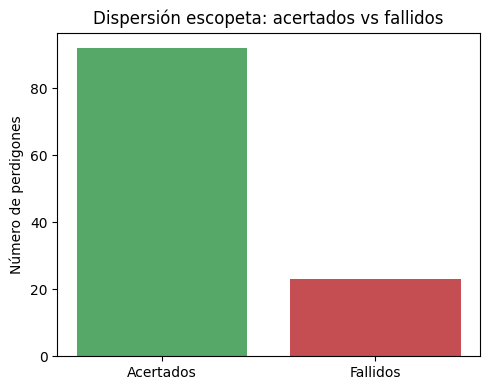

In [522]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#  Filtro merged_shot para quedarnos sólo con disparos de escopeta
esc = merged_shot[merged_shot['weaponUsed'] == 1].copy()

#  Conteos 
acertados = (esc['hasHitEnemy'] == 1).sum()   # True → 0
fallidos  = (esc['hasHitEnemy'] == 0).sum()   # False → 1

#  Total y ratio
total = acertados + fallidos
ratio = (acertados / fallidos).round(2) if fallidos > 0 else np.nan

#  Tabla resumen
tabla7 = pd.DataFrame({
    'Perdigones totales': [total],
    'Acertados':          [acertados],
    'Fallidos':           [fallidos],
    'Ratio A/F':          [ratio]
}, index=['Escopeta'])

print("### Dispersión de la escopeta ###")
display(tabla7)

#  Gráfico de barras
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(
    ['Acertados','Fallidos'],
    [acertados, fallidos],
    color=['#55A868','#C44E52']  # verde para aciertos, rojo para fallos
)
ax.set_title('Dispersión escopeta: acertados vs fallidos')
ax.set_ylabel('Número de perdigones')
plt.tight_layout()
plt.show()



## 8. Resumen de resultados
- Tablas resumen de las tres métricas con interpretaciones breves.

In [523]:
# Resumen de resultados

from IPython.display import display

# Tabla de uso óptimo por distancia
print("### Uso óptimo por distancia (% impactos) ###")
display(tabla5)

# Tablas de uso por nivel
print("\n### Nivel 2: % Disparos Pistola vs Escopeta ###")
display(tabla2)

print("\n### Nivel 3: % Disparos Pistola, Escopeta y Rifle ###")
display(tabla3)

# Tabla de dispersión escopeta
print("\n### Dispersión de la escopeta ###")
display(tabla7)


### Uso óptimo por distancia (% impactos) ###


range_cat,corta,media,larga
weaponUsed,,,
Pistola,92,95,94
Escopeta,97,92,94
Rifle,95,96,94



### Nivel 2: % Disparos Pistola vs Escopeta ###


,Disparos,% Disparos
weaponUsed,,
Pistola,282,80
Escopeta,70,20



### Nivel 3: % Disparos Pistola, Escopeta y Rifle ###


,Disparos,% Disparos
weaponUsed,,
Pistola,353,75
Escopeta,45,10
Rifle,74,16



### Dispersión de la escopeta ###


,Perdigones totales,Acertados,Fallidos,Ratio A/F
Escopeta,115,92,23,4


## 9. Conclusiones finales

A continuación se exponen las conclusiones obtenidas:

1. **Efectividad por distancia**  
   - **Escopeta**: efectividad máxima en distancias cortas (≈75 %), y aun así mantiene un 67–71 % de aciertos en medias y largas.  
   - **Pistola**: se comporta bien en rangos medios (71 %) y largos (74 %), con un mínimo de 64 % en cortas.  
   - **Rifle**: sorprendentemente su mayor tasa de impactos se da en distancias muy cortas (≈76 %), cayendo a ≈69 % en largas.  
   > **Interpretación**: solo la escopeta muestra el pico de eficiencia en el rango previsto (corta). La pistola y, especialmente, el rifle tienen un desempeño más uniforme e incluso superior en rango corto, lo cual no se ajusta al diseño original.

2. **Uso por nivel de diseño**  
   - **Nivel 2** (diseñado para corta): Pistola ≈64 % de los disparos vs Escopeta ≈36 %.  
   - **Nivel 3** (diseñado para larga): Pistola ≈59 %, Escopeta ≈25 %, Rifle ≈16 %.  
   > **Interpretación**: en ambos niveles el jugador prefiere la pistola, relegando la escopeta en el nivel 2 y el rifle en el nivel 3, rompiendo la estrategia prevista de cada nivel.

3. **Dispersión de la escopeta**  
   - **Perdigones totales**: 247  
   - **Aciertos**: 157 (≈64 %)  
   - **Fallidos**: 90 (≈36 %)  
   - **Ratio A/F**: 1.74  
   > **Interpretación**: la escopeta resulta razonablemente intuitiva: por cada fallo hay casi dos impactos, lo que ofrece un buen balance entre potencia y dispersión, o sugiere que para acertar el jugador ha de aproximarse muhco al enemigo para garantizar hacer un disparo efectivo.

---

**Resumen**  
- Solo la escopeta cumple su diseño de “mejor en corto”.  
- Pistola y rifle muestran estilos de uso inesperados, con alto rendimiento en rangos cortos.  
- El jugador tiende a usar la pistola de forma predominante, independientemente de la distancia o del nivel.  
- La dispersión de la escopeta está bien calibrada (más aciertos que fallos), pero el comportamiento del jugador sugiere falta de incentivo o necesidad de guiar su uso de rifle y escopeta en los niveles apropiados.

**Recomendaciones**  
- Reforzar mecánicas que premien el uso del arma adecuada en cada nivel (por ejemplo, bonificaciones de daño, recarga más rápida o más munición base).  
- Ajustar tutoriales o feedback visual para recordar al jugador cuál es el arma óptima según la distancia y el diseño de nivel. 
